In [16]:
import numpy as np
import matplotlib.pyplot as plt
import burst_detector as bd
import seaborn as sns
from scipy.stats import wasserstein_distance, pearsonr
import json
import pandas as pd
import os

In [87]:
n_chan = 385

ks_dir = "../data/rec_bank0_dense_g0/KS2.5/catgt_rec_bank0_dense_g0/rec_bank0_dense_g0_imec0/imec0_ks2/"

times = np.load(os.path.join(ks_dir, "spike_times.npy")).flatten()
clusters = np.load(os.path.join(ks_dir, "spike_clusters.npy")).flatten()
mean_wf = np.load(os.path.join(ks_dir, "mean_waveforms.npy"))

counts = bd.spikes_per_cluster(clusters)
labels = pd.read_csv(os.path.join(ks_dir, "cluster_group.tsv"), sep="\t", index_col=False)


channel_pos = np.load(os.path.join(ks_dir, "channel_positions.npy"))
channel_map = np.load(os.path.join(ks_dir, "channel_map.npy")).flatten()
templates = np.load(os.path.join(ks_dir, "templates.npy"))


f = open(os.path.join(ks_dir, "automerge", "old2new.json"))
old2new = json.load(f)

f = open(os.path.join(ks_dir, "automerge", "new2old.json"))
new2old = json.load(f)

### time splits

In [60]:
# calc metrics for each new cluster
times_multi = bd.find_times_multi(times/30000, clusters, np.arange(clusters.max()))

In [61]:
def calc_time_split(c1, c2, times_multi):
    c1, c2 = bd.bin_spike_trains(times_multi[c1], times_multi[c2], 20)
    c1a = np.zeros(124)
    c2a = np.zeros(124)
    c1a[:c1.shape[0]] = c1
    c2a[:c2.shape[0]] = c2

    c1b = c1a - c1a.mean()
    c2b = c2a- c2a.mean()
    mask = (c1a > .15*c1a.max()) | ((c2a > .15*c2a.max())) 
    c1b = c1b[mask]
    c2b = c2b[mask]

    r = pearsonr(c1b, c2b)
    return r.statistic

In [63]:
n_clust = clusters.max() + 1
time_splits = np.zeros(len(new2old.keys()))

for i in range(len(new2old.keys())):
    clusts = new2old[list(new2old.keys())[i]]
    time_splits[i] = calc_time_split(clusts[0], clusts[1], times_multi)

In [64]:
merged_ds = np.zeros(len(new2old.keys()))
for i in range(len(new2old.keys())):
    spike_times = []
    for clust in new2old[list(new2old.keys())[i]]:
        spike_times.append(times_multi[clust])
        
    spike_times = np.concatenate(spike_times)
    c1, _ = bd.bin_spike_trains(spike_times, spike_times, 20)
    n = c1.shape[0]
    merged_ds[i] = 1-wasserstein_distance(u_values=np.arange(n)/n, v_values=np.arange(n)/n, u_weights=c1, v_weights=np.ones(n))

In [65]:
single_ds = np.zeros(len(old2new.keys()))
for i in range(len(old2new.keys())):
    clust = int(list(old2new.keys())[i])
    spike_times = times_multi[clust]
    c1, _ = bd.bin_spike_trains(spike_times, spike_times, 20)
    n = c1.shape[0]
    single_ds[i] = 1-wasserstein_distance(u_values=np.arange(n)/n, v_values=np.arange(n)/n, u_weights=c1, v_weights=np.ones(n))

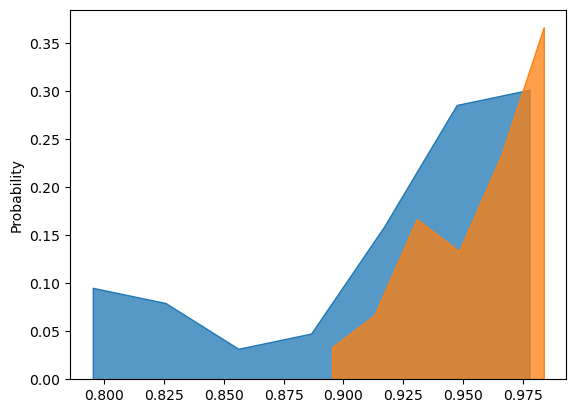

In [66]:
sns.histplot(single_ds, stat="probability", element="poly");
sns.histplot(merged_ds, stat="probability", element="poly");
plt.savefig("../figures/poster/metrics/fr_hippo_wass.svg", transparent=True)

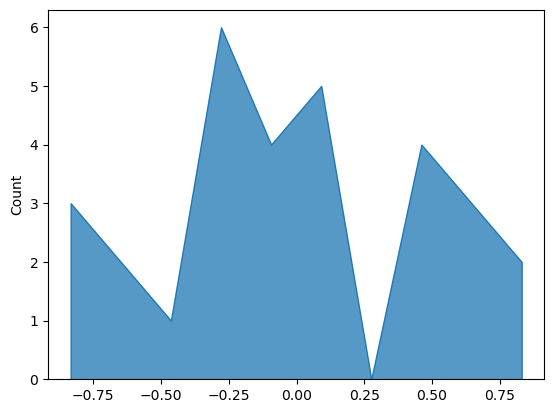

In [67]:
sns.histplot(time_splits, element="poly", bins=10);
plt.savefig("../figures/poster/metrics/fr_hippo_corr.svg", transparent=True)

### Spatial splits

In [80]:
def get_closest_channels(channel_positions, channel_index, n=None):
    """Get the channels closest to a given channel on the probe."""
    x = channel_positions[:, 0]
    y = channel_positions[:, 1]
    x0, y0 = channel_positions[channel_index]
    d = (x - x0) ** 2 + (y - y0) ** 2
    out = np.argsort(d)
    if n:
        out = out[:n]
    return out

In [81]:
def get_dists(channel_positions, ref_chan, target_chan):
    x = channel_positions[:, 0]
    y = channel_positions[:, 1]
    x0, y0 = channel_positions[ref_chan]
    d = (x - x0) ** 2 + (y - y0) ** 2
    # d[y < y0] *= -1
    return d[target_chan]

In [82]:
channel_shanks = (channel_pos[:,0]/250).astype("int")

In [83]:
def find_best_channels(template):
    amplitude_threshold = 0
    
    amplitude = template.max(axis=0) - template.min(axis=0)
    best_channel = np.argmax(amplitude)
    max_amp = amplitude[best_channel]
    
    peak_channels = np.nonzero(amplitude >= amplitude_threshold * max_amp)[0]
    
    close_channels = get_closest_channels(channel_pos, best_channel, 12)

    shank = channel_shanks[best_channel]
    channels_on_shank = np.nonzero(channel_shanks == shank)[0]
    close_channels = np.intersect1d(close_channels, channels_on_shank)
    channel_ids = np.intersect1d(close_channels, peak_channels)
    
    return channel_ids, best_channel

In [84]:
def calc_template_mismatch(clust_id, templates, channel_map, channel_pos, mean_wf):
    ch_ids, peak_channel = find_best_channels(templates[clust_id])
    
    # calculate and rank distances (proximity)
    dists = get_dists(channel_pos, peak_channel, ch_ids)
    prox_order = np.argsort(dists)
    prox_ranks = np.argsort(prox_order)
    
    # calculate and rank amplitudes
    means = mean_wf[clust_id, ch_ids, :]
    amp = means.max(axis=1) - means.min(axis=1)
    amp_order = np.argsort(amp)
    amp_ranks = np.argsort(amp_order)
    
    # calculate magnitude and direction of mismatch
    mismatch = np.abs((prox_ranks[prox_order] - amp_ranks[prox_order])[int(ch_ids.shape[0]/2):].sum()/26) # 26 is maximum possible raw mismatch
    direc = -2
    shift = channel_pos[ch_ids[amp.argmax()],1] - channel_pos[ch_ids[dists.argmin()], 1]
    
    if shift > 0:
        direc = 1
    elif shift == 0:
        direc = 0
    elif shift < 0:
        direc = -1
        
    return mismatch
# , direc, peak_channel

In [89]:
labels.loc[labels['cluster_id']==i, 'group']

Series([], Name: group, dtype: object)

In [107]:
# calculate template mismatch per cluster
# mismatch = np.zeros(n_clust)
mismatch = []
direc = np.zeros(n_clust)
peak_channel = np.zeros(n_clust)

for i in range(n_clust):
    if (i in counts) and (labels.loc[labels['cluster_id']==i, 'group'].item() == 'good'):
        # mismatch[i] = calc_template_mismatch(i, templates, channel_map, channel_pos, mean_wf)
        mismatch.append(calc_template_mismatch(i, templates, channel_map, channel_pos, mean_wf))

In [108]:
len(mismatch)

286

In [104]:
spatial_splits = np.zeros((n_clust,n_clust))

# assess cluster pairs
for i in range(n_clust):
    # for j in range(n_clust):
    #         if np.abs(peak_channel[i] - peak_channel[j]) <= 12:
    spatial_splits[i,j] = (mismatch[i] + mismatch[j])/2

IndexError: list index out of range

In [92]:
n_clust = clusters.max() + 1
spat_splits = np.zeros(len(new2old.keys()), dtype="object")

for i in range(len(new2old.keys())):
    clusts = new2old[list(new2old.keys())[i]]
    mets = np.zeros(len(clusts))
    for j in range(len(clusts)):
        mets[j] = calc_template_mismatch(clusts[j], templates, channel_map, channel_pos, mean_wf)
    spat_splits[i] = mets
    # spat_splits[i,0] = calc_template_mismatch(clusts[0], templates, channel_map, channel_pos, mean_wf) 
    # spat_splits[i,1] = calc_template_mismatch(clusts[1], templates, channel_map, channel_pos, mean_wf)

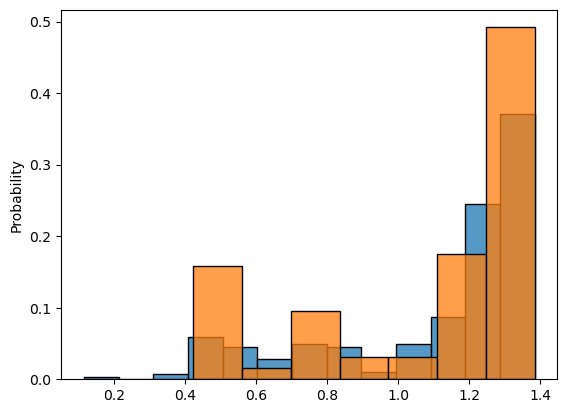

In [110]:
sns.histplot(mismatch, stat="probability");
sns.histplot(np.concatenate(spat_splits), stat="probability");
# plt.savefig("../figures/poster/metrics/spatial_split_hippo.svg", transparent=True)

### Bursting

In [96]:
pre_q = np.zeros(len(old2new.keys()), dtype="object")
pre_a = np.zeros(len(old2new.keys()), dtype="object")
for i in range(len(old2new.keys())): 
    if i%2:
        print(i)
    key = int(list(old2new.keys())[i])
    _, pre_q[i], pre_a[i] = bd.find_bursts(times_multi[key], s=3, gamma=.1)

1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39
41
43
45
47
49
51
53
55
57
59
61


In [111]:
post_q = np.zeros(len(new2old.keys()), dtype="object")
post_a = np.zeros(len(new2old.keys()), dtype="object")
for i in range(len(new2old.keys())):
    if i%2:
        print(i)
    spike_times = []
    for clust in new2old[list(new2old.keys())[i]]:
        spike_times.append(times_multi[clust])
    spike_times = np.concatenate(spike_times)
    
    _, post_q[i], post_a[i] = bd.find_bursts(spike_times, s=3, gamma=.1)        

1


c:\users\harris_lab\projects\burst-detector\burst_detector\bursts.py:49: RuntimeWarning: divide by zero encountered in double_scalars
  k = int(np.ceil(1+np.emath.logn(s, T)+np.emath.logn(s, 1/gaps.min())))


OverflowError: cannot convert float infinity to integer

In [483]:
# convert pre to array
thresh = 50
pre_bursts = np.zeros(n_clust)
pre_int = np.zeros(n_clust)
for i in range(len(old2new.keys())): 
    a_thresh = np.where(pre_a[i] > thresh)[0]
    key = int(list(old2new.keys())[i])
    if a_thresh.shape[0] == 0:
        pre_bursts[key] = 0
    else:
        lvl_thresh = a_thresh.min()
        labels = label_spikes(pre_q[i], lvl_thresh).sum()
        pre_bursts[key] = labels.sum()
        pre_q[i][pre_q[i] >= pre_a[i].shape[0]] = pre_a[i].shape[0]-1
        pre_int[key] = pre_a[i][pre_q[i][pre_q[i] >= lvl_thresh].astype("int")].mean()

C:\Users\Harris_Lab\AppData\Local\Temp\ipykernel_21272\1386462941.py:15: RuntimeWarning: Mean of empty slice.
  pre_int[key] = pre_a[i][pre_q[i][pre_q[i] >= lvl_thresh].astype("int")].mean()
C:\Users\Harris_Lab\miniconda3\envs\burst-detector\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [534]:
new_bursts = np.zeros(post_q.shape[0])
new_bursts_pct = np.zeros(post_q.shape[0])
post_bursts = np.zeros(post_q.shape[0])
ch_int = np.zeros(post_q.shape[0])
post_int = np.zeros(post_q.shape[0])

for i in range(post_q.shape[0]):
    old_bursts = 0
    old_int = 0
    for clust in new2old[list(new2old.keys())[i]]:
        old_bursts += pre_bursts[clust]
        old_int += pre_int[clust]*pre_bursts[clust]
        
    if old_bursts>0:
        old_int /= old_bursts
        
    a_thresh = np.where(post_a[i] > thresh)[0]
    key = int(list(new2old.keys())[i])
    if a_thresh.shape[0] == 0:
        post_bursts[i] = 0
    else: 
        lvl_thresh = a_thresh.min()
        labels = label_spikes(post_q[i], lvl_thresh).sum()
        post_bursts[i] = labels.sum()

        new_bursts[i] = max(post_bursts[i] - old_bursts,0)
        if old_bursts != 0:
            new_bursts_pct[i] = new_bursts[i]/old_bursts
            
        post_q[i][post_q[i] >= post_a[i].shape[0]] = post_a[i].shape[0]-1
        post_int[i] = post_a[i][post_q[i][post_q[i] >= lvl_thresh].astype("int")].mean()
        
        ch_int[i] = max(post_int[i] - old_int, 0)/old_int

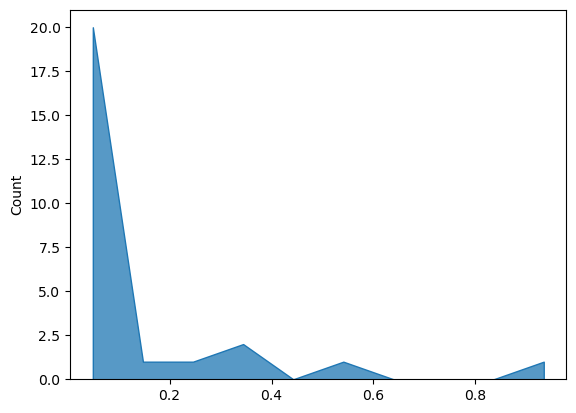

In [537]:
sns.histplot(new_bursts_pct, bins=10, element="poly");
plt.savefig("../figures/poster/metrics/newburstpct_hippo.svg", transparent=True)

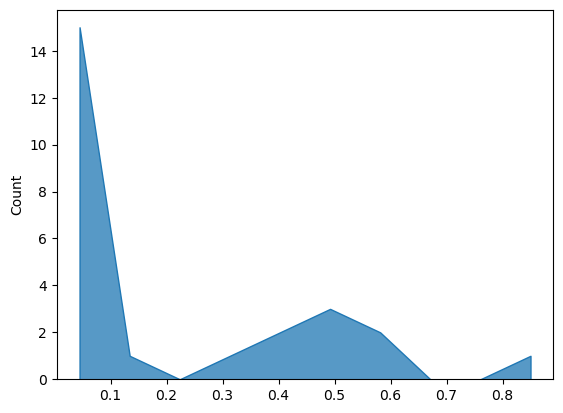

In [538]:
sns.histplot(ch_int, bins=10, element="poly");
plt.savefig("../figures/poster/metrics/chint_hippo.svg", transparent=True)

In [ ]:
def label_spikes(q, lvl_thresh):
    labels = np.zeros(q.shape[0]+1, dtype="bool")
    labels2 = np.zeros(q.shape[0]+1, dtype="bool")
    
    # edges
    labels[0] = q[0] >= lvl_thresh
    labels[-1] = q[-1] >= lvl_thresh
    
    # middle
    for i in range(1, q.shape[0]-1):
        if (q[i-1] < lvl_thresh) and (q[i] < lvl_thresh):
            labels[i] = False
        else:
            labels[i] = True
            
    # ignore bursts with < 3 spikes
    burst = False
    for i in range(labels.shape[0]):
        # check if in a burst
        if not labels[i]:
            burst = False
        else:
            if labels.shape[0]-i <= 2:
                burst = burst
            else:
                burst = burst or (labels[i+1] and labels[i+2])

        labels2[i] = burst
        
    return labels2